In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import csv
import seaborn as sns
import sklearn.metrics
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, accuracy_score, auc 
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
from sklearn import svm
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
headers = ['unit_number','time_in_cycles','setting_1','setting_2','setting_3','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

In [3]:
#Simulation number
i=1

In [4]:
train_file_path = 'train_FD00'+str(i)+'.txt'

train_df=pd.read_csv(train_file_path, sep='\s+', header=None, names=headers)
train_df=train_df[train_df.columns[train_df.std()>0.00000001]]

train_df['RUL']=(-1)*(train_df['time_in_cycles']-
                                         train_df.groupby("unit_number")['time_in_cycles'].transform('max'))


In [5]:
#0: not faulty, 1: last cycle of the engine, faulty

train_df['faulty']=0    
faulty_index=train_df['RUL']==0
train_df.loc[faulty_index,'faulty']=1

train_df_new=train_df.drop(columns=["RUL","unit_number","faulty","P15"])

In [6]:
train, test = train_test_split(train_df, random_state=10, test_size = 0.2, stratify=train_df.faulty)
X_train = train.drop(columns=["RUL","unit_number","faulty","P15"])   #for simulation 1
y_train = train['faulty']
X_test = test.drop(columns=["RUL","unit_number","faulty","P15"])
y_test = test['faulty']

In [8]:
#Most of our observations are not faulty. To deal with that, balanced accuracy or undersampling can be used.

logreg = LogisticRegression(solver='liblinear', random_state=42).fit(X_train, y_train)
cm = confusion_matrix(logreg.predict(X_test),y_test)
TP = cm[1,1]     
TN = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
N = TN+FP
P = TP+FN
#recall = TP / float(TP + FN)
#precision = TP / float(TP + FP)

print(f'Type I Error: {FP/N:.4f}')                 #minimize type II error
print(f'Type II Error: {FN/P:.4f}')

print(f'Accuracy: {accuracy_score(y_test, logreg.predict(X_test))}')
#print(f'ROC AUC Score: {roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])}')

print(f'Balanced Accuracy: {(TP/P+TN/N)/2}')         #maximize balanced accuracy

Type I Error: 0.0007
Type II Error: 0.8000
Accuracy: 0.9953961715531864
Balanced Accuracy: 0.5996347699050402


In [9]:
cm

array([[4104,   16],
       [   3,    4]], dtype=int64)

In [10]:
rf = RandomForestClassifier(random_state=7).fit(X_train, y_train)
cm = confusion_matrix(rf.predict(X_test),y_test)
TP = cm[1,1]     
TN = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
N = TN+FP
P = TP+FN
#recall = TP / float(TP + FN)
#precision = TP / float(TP + FP)

print(f'Type I Error: {FP/N:.4f}')
print(f'Type II Error: {FN/P:.4f}')

print(f'Accuracy: {accuracy_score(y_test, rf.predict(X_test))}')
#print(f'ROC AUC Score: {roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])}')

print(f'Balanced Accuracy: {(TP/P+TN/N)/2}')

Type I Error: 0.0002
Type II Error: 0.9000
Accuracy: 0.9953961715531864
Balanced Accuracy: 0.5498782566350134


In [16]:
cross_val_score(RandomForestClassifier(), X_train, y_train, cv = 10, scoring='balanced_accuracy').mean()

0.5186586850574133

In [35]:
cross_val_score(LogisticRegression(solver='liblinear'), train_df_new, train_df['faulty'], cv = 10, scoring='recall').mean()

0.08

In [22]:
cross_val_score(SVC(kernel='linear'), train_df_new, train_df['faulty'], cv = 10, scoring='balanced_accuracy').mean()

0.5

In [23]:
cross_val_score(LinearDiscriminantAnalysis(), X_train, y_train, cv = 10, scoring='balanced_accuracy').mean()

0.6224125456018705

In [30]:
#type 2 error
1-cross_val_score(QuadraticDiscriminantAnalysis(), X_train, y_train, cv = 10, scoring='recall').mean()

0.4

In [31]:
1-cross_val_score(GaussianNB(), X_train, y_train, cv = 10, scoring='recall').mean()


1.0

In [27]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

cross_val_score(KNeighborsClassifier(n_neighbors=20), X_train_scaled, y_train, cv = 10, scoring='balanced_accuracy')

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [34]:
1-cross_val_score(xgb.XGBClassifier(), X_train, y_train, cv = 10, scoring='recall').mean()   #scaling doesn't affect

0.8625

In [ ]:
#QDA, Random Forest and Naive Bayes seem to be the best models in terms of type II error

In [37]:
nb = GaussianNB().fit(X_train, y_train)
cm = confusion_matrix(nb.predict(X_test),y_test)
TP = cm[1,1]     
TN = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
N = TN+FP
P = TP+FN
#recall = TP / float(TP + FN)
#precision = TP / float(TP + FP)

print(f'Type I Error: {FP/N:.4f}')
print(f'Type II Error: {FN/P:.4f}')

print(f'Accuracy: {accuracy_score(y_test, nb.predict(X_test))}')
#print(f'ROC AUC Score: {roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])}')

print(f'Balanced Accuracy: {(TP/P+TN/N)/2}')

Type I Error: 0.0816
Type II Error: 0.0000
Accuracy: 0.9188272352798643
Balanced Accuracy: 0.9592159727294862


In [107]:
#changing the threshold
threshold = [0.9,0.99,0.999,0.999,0.9999,0.99999,0.999999]  #,0.8,0.9,0.95,0.99,0.999]
qda_typ2=[]
qda_bal_acc=[]
qda_acc=[]

for i in threshold:
    random_forest = GaussianNB().fit(X_train, y_train)
    predicted_proba = random_forest.predict_proba(X_test)
    predicted = (predicted_proba [:,1] >= i)          #.astype('int')
    cm = confusion_matrix(predicted, y_test )
    
    TP = cm[1,1]     
    TN = cm[0,0]
    FN = cm[0,1]
    FP = cm[1,0]
    N = TN+FP
    P = TP+FN
    
    qda_typ2.append(FN/P)
    qda_bal_acc.append((TP/P+TN/N)/2)
    qda_acc.append((TP+TN)/len(y_test))

Text(0.5, 1.0, 'Naive Bayes')

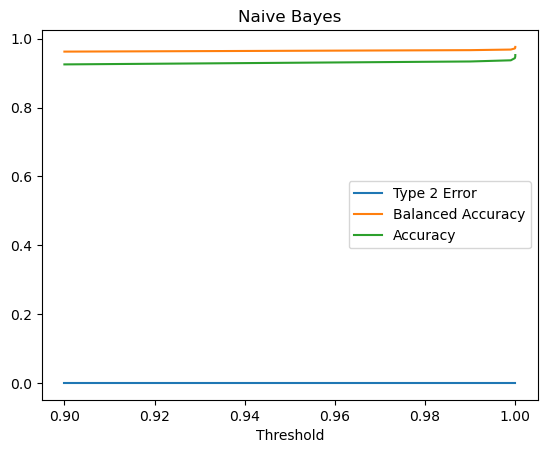

In [108]:
plt.figure()
plt.plot(threshold,qda_typ2,label="Type 2 Error")
plt.plot(threshold,qda_bal_acc,label="Balanced Accuracy")
plt.plot(threshold,qda_acc,label="Accuracy")
plt.legend()
plt.xlabel('Threshold')
plt.title("Naive Bayes")

In [111]:
#just to see the pattern of type2 error and balanced accuracy
print(rf_typ2)
print(rf_bal_acc)

[0.0, 0.0, 0.1, 0.1, 0.2, 0.5, 0.75, 0.85, 1.0]
[0.9735816897979059, 0.9735816897979059, 0.9375821767713659, 0.9420866812758705, 0.8970781592403214, 0.7491477964450937, 0.6248782566350134, 0.5748782566350134, 0.5]


In [116]:
print(nb_typ2)
print(nb_bal_acc)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.9526418310202094, 0.954589724859995, 0.9553201850499148, 0.9565376186997809, 0.9578767957146336, 0.9586072559045532, 0.9592159727294862, 0.9597029461894326, 0.960555149744339, 0.9614073532992452, 0.9625030435841246, 0.9637204772339907, 0.9667640613586559, 0.9684684684684685]


In [109]:
print(qda_typ2)
print(qda_bal_acc)
print(qda_acc)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.9625030435841246, 0.9667640613586559, 0.9684684684684685, 0.9684684684684685, 0.9716337959581203, 0.9738251765278793, 0.9761383004626247]
[0.9253695178095469, 0.9338502544220983, 0.937242549067119, 0.937242549067119, 0.943542524836443, 0.947904046522898, 0.9525078749697117]


In [110]:
threshold = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99,0.999,0.99999]

rf_t2_all=[]
rf_ba_all=[]

nb_t2_all=[]
nb_ba_all=[]

for j in range(10):
            train, test = train_test_split(train_df, random_state=10*j, test_size = 0.2, stratify=train_df.faulty)
            X_train = train.drop(columns=["RUL","unit_number","faulty","P15"])   #for simulation 1
            y_train = train['faulty']
            X_test = test.drop(columns=["RUL","unit_number","faulty","P15"])
            y_test = test['faulty']

            model = GaussianNB().fit(X_train, y_train)
            #model = RandomForestClassifier().fit(X_train, y_train)
            rf_t2=[]
            rf_ba=[]
            for i in threshold:
                
                predicted_proba = model.predict_proba(X_test)
                predicted = (predicted_proba [:,1] >= i)          #.astype('int')
        
                cm = confusion_matrix(predicted, y_test )
    
                TP = cm[1,1]     
                TN = cm[0,0]
                FN = cm[0,1]
                FP = cm[1,0]
                N = TN+FP
                P = TP+FN
        
                rf_t2.append(FN/P)
                rf_ba.append((TP/P+TN/N)/2)

            #nb_t2_all.append(rf_t2)
            #nb_ba_all.append(rf_ba)
            
            rf_t2_all.append(rf_t2)
            rf_ba_all.append(rf_ba)
    
    
    

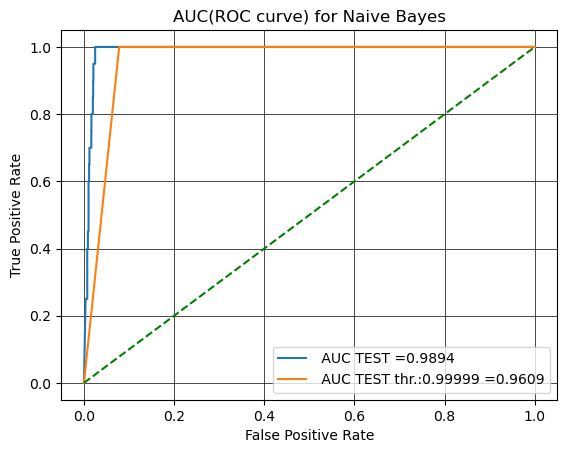

In [111]:
test_fpr, test_tpr, te_thresholds = sklearn.metrics.roc_curve(y_test, GaussianNB().fit(X_train, y_train).predict_proba(X_test)[:,1])
test_fpr1, test_tpr1, te_thresholds = sklearn.metrics.roc_curve(y_test, GaussianNB().fit(X_train, y_train).predict_proba(X_test)[:,1]>=0.1)

plt.grid()


plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(round(auc(test_fpr, test_tpr),4)))
plt.plot(test_fpr1, test_tpr1, label=" AUC TEST thr.:0.99999 ="+str(round(auc(test_fpr1, test_tpr1),4)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve) for Naive Bayes")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [81]:
#sklearn.metrics.get_scorer_names()

In [11]:
#undersampling
nr = NearMiss()
  
X_train_miss, y_train_miss = nr.fit_resample(X_train, y_train.to_numpy())
X_test_miss, y_test_miss = nr.fit_resample(X_test, y_test.to_numpy())

In [12]:
logreg = LogisticRegression(solver='liblinear', random_state=42).fit(X_train_miss, y_train_miss)
cm = confusion_matrix(logreg.predict(X_test),y_test)
TP = cm[1,1]     
TN = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
N = TN+FP
P = TP+FN
#recall = TP / float(TP + FN)
#precision = TP / float(TP + FP)

print(f'Type I Error: {FP/N:.4f}')
print(f'Type II Error: {FN/P:.4f}')

print(f'Accuracy: {accuracy_score(y_test_miss, logreg.predict(X_test_miss))}')
print(f'ROC AUC Score: {roc_auc_score(y_test_miss, logreg.predict_proba(X_test_miss)[:, 1])}')


Type I Error: 0.0156
Type II Error: 0.2500
Accuracy: 0.775
ROC AUC Score: 0.8675


In [13]:
rf = RandomForestClassifier(random_state=7).fit(X_train_miss, y_train_miss)
cm = confusion_matrix(rf.predict(X_test),y_test)
TP = cm[1,1]     
TN = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
N = TN+FP
P = TP+FN
#recall = TP / float(TP + FN)
#precision = TP / float(TP + FP)

print(f'Type I Error: {FP/N:.4f}')
print(f'Type II Error: {FN/P:.4f}')

print(f'Accuracy: {accuracy_score(y_test_miss, rf.predict(X_test_miss))}')
print(f'ROC AUC Score: {roc_auc_score(y_test_miss, rf.predict_proba(X_test_miss)[:, 1])}')



Type I Error: 0.0419
Type II Error: 0.0500
Accuracy: 0.825
ROC AUC Score: 0.91125


In [15]:
rf = RandomForestClassifier(random_state=7).fit(X_train_miss, y_train_miss)

predicted_proba = rf.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= 0.1)          #.astype('int')
cm = confusion_matrix(predicted, y_test )

TP = cm[1,1]     
TN = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
N = TN+FP
P = TP+FN
#recall = TP / float(TP + FN)
#precision = TP / float(TP + FP)

print(f'Type I Error: {FP/N:.4f}')
print(f'Type II Error: {FN/P:.4f}')

print(f'Accuracy: {accuracy_score(y_test_miss, rf.predict(X_test_miss))}')
print(f'ROC AUC Score: {roc_auc_score(y_test_miss, rf.predict_proba(X_test_miss)[:, 1])}')



Type I Error: 0.9929
Type II Error: 0.0000
Accuracy: 0.825
ROC AUC Score: 0.91125
